# ECSE 415 Assignment 2, Question 3
### Alex Hale | 260672475 | October 20, 2019

## Object Detection
### Step 1 - Training

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# return a vector of HoG features for the supplied image
def hog(img, cell_size_h=4, cell_size_w=4, block_size_h=2, block_size_w=2, orient_bins=9):
    cell_size = (cell_size_h, cell_size_w)  # h x w in pixels
    block_size = (block_size_h, block_size_w)  # h x w in cells
    nbins = orient_bins  # number of orientation bins
    
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img) \
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[1], block_size[0], nbins) \
                   .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
    
    return (hog_feats)

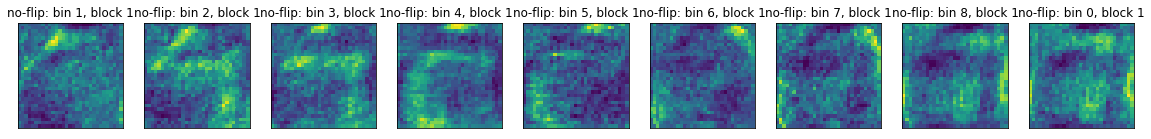

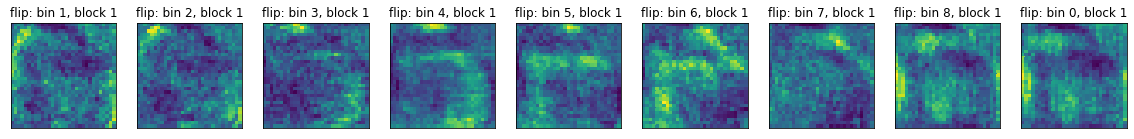

In [3]:
cars = []
cars_flipped = []
feat_vecs = []
feat_vecs_flipped = []

# import and execute HoG on each training image
for i in range(14):
    cars.append(cv2.resize(cv2.cvtColor(cv2.imread("car" + str(i+1) + ".jpg"), cv2.COLOR_BGR2GRAY), (128, 128)))
    feat_vecs.append(hog(cars[i]))
    cars_flipped.append(cv2.flip(cars[i], 1))
    feat_vecs_flipped.append(hog(cars_flipped[i]))

# calculate and store the mean feature vector across the training images
mean_feat_vec = sum(feat_vecs) / len(feat_vecs)
flipped_mean_feat_vec = sum(feat_vecs_flipped) / len(feat_vecs_flipped)

# display all 9 orientation channels of the mean feature maps, for only the first block
plt.figure(figsize = (20,100))
for o_bin in range(mean_feat_vec.shape[4]):
    plt.subplot("19" + str(o_bin))
    plt.pcolor(mean_feat_vec[:, :, 0,0,o_bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("no-flip: bin " + str(o_bin) + ", block 1"), plt.xticks([]), plt.yticks([])
plt.show()

# display all 9 orientation channels of the mean feature maps (of the flipped images), for only the first block
plt.figure(figsize = (20,100))
for o_bin in range(flipped_mean_feat_vec.shape[4]):
    plt.subplot("19" + str(o_bin))
    plt.pcolor(flipped_mean_feat_vec[:, :, 0,0,o_bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("flip: bin " + str(o_bin) + ", block 1"), plt.xticks([]), plt.yticks([])
plt.show()

### Step 2 - Testing

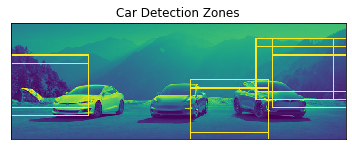

In [4]:
# load test image
test_img = cv2.cvtColor(cv2.imread("test.jpg"), cv2.COLOR_BGR2GRAY)
clone = test_img.copy()

# set window size, stride, and threshold
w = [190, 128]      # (width, height)
s = [40, 20]        # (x, y)
threshold = 20.95   # determined by trial-and-error

for y in range(0, test_img.shape[0] - w[1] + s[1], s[1]):
    for x in range(0, test_img.shape[1] - w[0] + s[0], s[0]):
        # get the window from the image
        window = test_img[y:y + w[1], x:x + w[0]]
        
        # get the HoG feature map of the window
        hog_map = hog(cv2.resize(window, (128, 128)))
        
        # calculate the distance from the mean feature map of the training images
        euclidian_dist = cv2.norm(hog_map, mean_feat_vec)
        euclidian_dist_flipped = cv2.norm(hog_map, flipped_mean_feat_vec)
        
        t1 = euclidian_dist < threshold
        t2 = euclidian_dist_flipped < threshold

        # if the distance is low enough, display this window on the image
            # taking the exclusive OR of the thresholds reduces false positives
        if (t1 and not t2) or (t2 and not t1):
            cv2.rectangle(clone, (x, y), (x + w[0], y + w[1]), (255, 0, 0), 2)

plt.imshow(clone)
plt.title("Car Detection Zones"), plt.xticks([]), plt.yticks([])
plt.show()